# Normalized Difference Vegetation Index

## 1 Overview

This notebook makes the GIMMS NDVI data compatible with ERA-INTERIM data, **temporal and spatially**:

 - First we need to create a regrid file using xarray and xesmf packages. This file translates from original GIMMS NDVI grid (2610 x 4320) to ERA-INTERIM one (241 x 480).
 
 - Then we create the new files using the above regridder file. **Please note that we do not make any manipulations before regridding**. It is necessary to perform a linear transformation and a cutting into data in order to retrieve valid NDVI values. This step is done in the new regridded files.
 
 - With the regridded files, first we make the transformation to retrieve valid range of NDVI data, and then we calculate the monthly means creating a netcdf file for each year. These final files will be compatible with monthly means from ERA-INTERIM variables.  
 
 - Finally, we read these monthly means files in order to visualize some data.

## 2 Initial setup

In [1]:
# Load packages
import sys
import glob
import os

import xarray as xr
import xesmf as xe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
print("Python:", sys.version)
print("Xarray:", xr.__version__)
print("Pandas:", pd.__version__)

Python: 3.6.8 |Anaconda, Inc.| (default, Dec 30 2018, 01:22:34) 
[GCC 7.3.0]
Xarray: 0.11.0
Pandas: 0.23.4


In [3]:
# My repository.
repository = "/home/alex/Dropbox/repositories/doctoral_thesis/libraries/"

In [4]:
# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my libraries.
import maps.data as dt    
import time_series.tools as tst

In [5]:
# Original data.
FOLDER_IN = "/media/alex/ALEXDATA/data_sets/GIMMS/NDVI/"

# All files there.
FILES_IN = sorted(glob.glob(FOLDER_IN + "*[0-9].nc4"))

In [6]:
# South America.
loni, lonf, lati, latf = -90, -30, 20, -60

## 3 Create regridder file

In [7]:
%%time

# As xarray Dataset object. Just the first file for creating the regrid file.
DATASET = xr.open_dataset(FILES_IN[0])

CPU times: user 12.3 ms, sys: 4.07 ms, total: 16.4 ms
Wall time: 16.3 ms


In [8]:
# Let's see it. 
DATASET

<xarray.Dataset>
Dimensions:     (lat: 2160, lon: 4320, time: 12)
Coordinates:
  * lon         (lon) float64 -180.0 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * lat         (lat) float64 89.96 89.88 89.79 89.71 ... -89.79 -89.88 -89.96
  * time        (time) float64 7.0 7.5 8.0 8.5 9.0 ... 10.5 11.0 11.5 12.0 12.5
Data variables:
    satellites  (time) int16 ...
    ndvi        (time, lat, lon) float32 ...
    percentile  (time, lat, lon) int16 ...
Attributes:
    FileName:              ndvi3g_geo_v1_1981_0712.nc4
    Institution:           NASA/GSFC GIMMS
    Data:                  NDVI3g version 1
    Reference:             1. Pinzon, J.E.; Tucker, C.J.                     ...
    CommentsVersion1:      version1 includes two major fixes (a and b), and t...
    Temporalrange:         1981-07-01 -> 2015-12-31
    Year:                  1981.0
    RangeSemester:         Jul 1 - Dec 31 (7:0.5:12.5)
    SpatialResolution:     1/12 x 1/12 degrees
    TemporalResolution:    1/24 a year
  

In [9]:
# In accordance with ERA-INTERIM pos-processed data (after shifting longitudes from 0 ... 360
# to -180 ... 180).
NEW_GRID = xr.Dataset({
    "lat": (["lat"], np.arange(90.00, -90.01, -0.75)),
    "lon": (["lon"], np.arange(-180.00, 180.00, 0.75)),
})

NEW_GRID

<xarray.Dataset>
Dimensions:  (lat: 241, lon: 480)
Coordinates:
  * lat      (lat) float64 90.0 89.25 88.5 87.75 ... -87.75 -88.5 -89.25 -90.0
  * lon      (lon) float64 -180.0 -179.2 -178.5 -177.8 ... 177.8 178.5 179.2
Data variables:
    *empty*

**The cell bellow takes some time and consumes a lot of ram, but the netcdf file needs to be created just once. The %%time command returns the following message on its first time run:**

```
Create weight file: bilinear_2160x4320_241x480.nc

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_2160x4320_241x480.nc 
Reuse pre-computed weights? True 
Input grid shape:           (2160, 4320) 
Output grid shape:          (241, 480) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

CPU times: user 2min 1s, sys: 3.65 s, total: 2min 4s
Wall time: 2min 5s
```

In [10]:
# Regridder object.
REGRIDDER = xe.Regridder(DATASET, NEW_GRID, "bilinear", reuse_weights=True)
REGRIDDER

Reuse existing file: bilinear_2160x4320_241x480.nc


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_2160x4320_241x480.nc 
Reuse pre-computed weights? True 
Input grid shape:           (2160, 4320) 
Output grid shape:          (241, 480) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

## 4 Create new regridded files

**These new files will be in the original range of values for the ndvi variable. Later, it is necessary to perform a linear transformation to the valid range [-0.3, 1.0].**

In [11]:
# Message.
print("In", FOLDER_IN + " :")

# Loop over input files.
for FILE_IN in FILES_IN:
    
    # Extract input file name without extension.
    name = os.path.basename(FILE_IN) # File name with extension.
    name = os.path.splitext(name)[0] # File name withou extension.
    
    # Out put file path.
    out_file_name = name + "_regridded" + ".nc4"
    out_file_path = FOLDER_IN + out_file_name    
    
    # Continue only if data file does not exist yet.
    if not os.path.isfile(out_file_path):    
    
        # Message.
        print("Creating", out_file_name, "...")
        
        # Read data.
        NDVI = xr.open_dataset(FILE_IN) # Xarray Dataset object.
        NDVI = NDVI.ndvi                # Xarray DataArray object.
                
        # Regrid data.
        NDVI = REGRIDDER(NDVI)
    
        # The same name as ERA-INTERIM data sets.abs
        NDVI = NDVI.rename({"lon": "longitude", "lat": "latitude"})
    
        # Export regridded data (same time resolution as the original data) into
        # the input folder. 
        NDVI.to_netcdf(path=out_file_path)
        
    else:
        
        # Message.
        print("Warning:", out_file_name, "has already been created!")

In /media/alex/ALEXDATA/data_sets/GIMMS/NDVI/ :


## 5 Create files for monthly mmeans of valid NDVI data

In [12]:
# Read all regridded data.
FILES_RE_IN = sorted(glob.glob(FOLDER_IN + "*regridded.nc4"))

# Load meta-data.
DATASET_RE = xr.open_mfdataset(FILES_RE_IN)

# Show it.
DATASET_RE

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 828)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) float64 7.0 7.5 8.0 8.5 9.0 ... 10.5 11.0 11.5 12.0 12.5
Data variables:
    ndvi       (time, latitude, longitude) float64 dask.array<shape=(828, 241, 480), chunksize=(12, 241, 480)>

In [13]:
# Scale factor and valid range of data [-0.3, 1.0].
NDVI = (DATASET_RE.ndvi / 1e4)
NDVI = NDVI.where(cond=(NDVI > -0.3), other=-0.3)
NDVI = NDVI.where(cond=(NDVI < 1.0), other=1.0)

# Make time coordinate as datetime.
NDVI["time"] = pd.date_range(start="1981-07-01", end="2015-12-31", periods=NDVI.time.size)

# Show it.
NDVI

<xarray.DataArray 'ndvi' (time: 828, latitude: 241, longitude: 480)>
dask.array<shape=(828, 241, 480), dtype=float64, chunksize=(12, 241, 480)>
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 1981-07-01 ... 2015-12-31

In [14]:
# Resample data as monthly means.
NDVI_mm = NDVI.resample(time="MS").mean("time")

In [15]:
NDVI_mm

<xarray.DataArray 'ndvi' (time: 414, latitude: 241, longitude: 480)>
dask.array<shape=(414, 241, 480), dtype=float64, chunksize=(1, 241, 480)>
Coordinates:
  * time       (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2015-12-01
  * longitude  (longitude) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0

In [16]:
# Output folder.
FOLDER_OUT = "/media/alex/ALEXDATA/data_sets/GIMMS/NDVI_mmeans/"

# Pandas date times.
dates = pd.to_datetime(NDVI_mm.time.values)

# Range of dates. 
years = dates.year.unique()
number_of_iterations = years.size 

# Root for file name.
ROOT = "ndvi_regridded_mmeans_"

# Message.
print("In", FOLDER_OUT + " :")

# Loop over each month in each year.
for year in years:
        
    # Data file.
    FILE_NAME = ROOT + "{0:04d}.nc4".format(year)
    FILE_PATH = FOLDER_OUT + FILE_NAME
        
    # Continue only if data file does not exist yet.
    if not os.path.isfile(FILE_PATH):
    
        # Message.
        print("Creating", FILE_NAME, "...") 
    
        # Select data corresponding to this date.
        DATASET = NDVI_mm.sel(time=str(year))
            
        # Export selected data as a netcdf file.
        DATASET.to_netcdf(FILE_PATH)
        
    else:
        
        # Message.
        print("Warning:", FILE_NAME, "has already been created!")

In /media/alex/ALEXDATA/data_sets/GIMMS/NDVI_mmeans/ :


## 6 Read and visualize final files

In [17]:
# Load meta-data.
NDVI_re_mm = xr.open_mfdataset(sorted(glob.glob(FOLDER_OUT + "*.nc4")))

# Show it.
NDVI_re_mm

<xarray.Dataset>
Dimensions:    (latitude: 241, longitude: 480, time: 414)
Coordinates:
  * longitude  (longitude) float64 -180.0 -179.2 -178.5 ... 177.8 178.5 179.2
  * latitude   (latitude) float64 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 1981-07-01 1981-08-01 ... 2015-12-01
Data variables:
    ndvi       (time, latitude, longitude) float64 dask.array<shape=(414, 241, 480), chunksize=(6, 241, 480)>

In [18]:
# Extract data as numpy arrays.
DATA = NDVI_re_mm.ndvi.groupby("time.month").mean("time").values

# Longitude and latitude 2d arrays.
LON, LAT = np.meshgrid(NDVI_re_mm.longitude.values, NDVI_re_mm.latitude.values) 

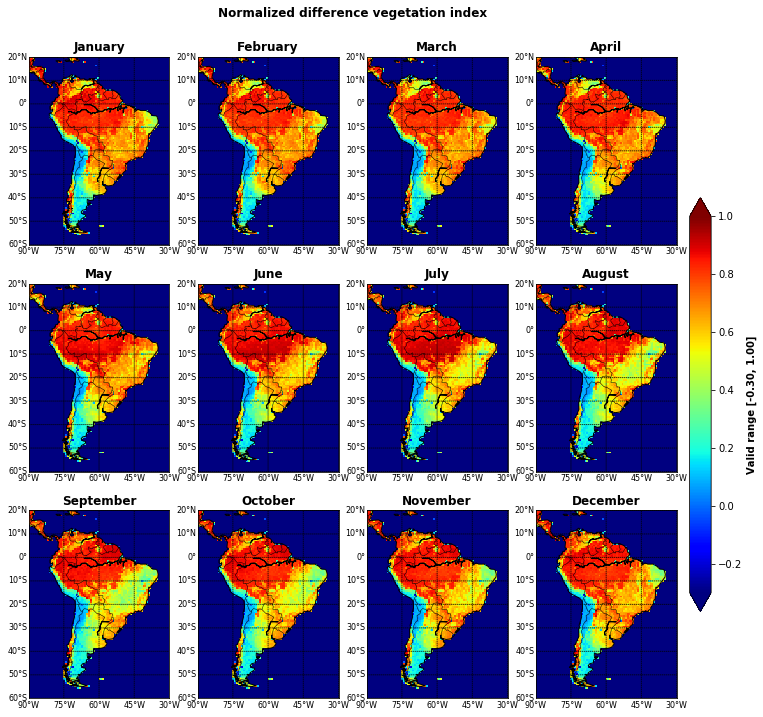

In [19]:
# Make maps.
dt.regional_scalar_monthly_means(DATA, LON, LAT, loni, lonf, lati, latf,
                                 cmap=plt.cm.jet, clim=(-0.30, 1.00), 
                                 title="Normalized difference vegetation index",  
                                 clabel="Valid range [-0.30, 1.00]")

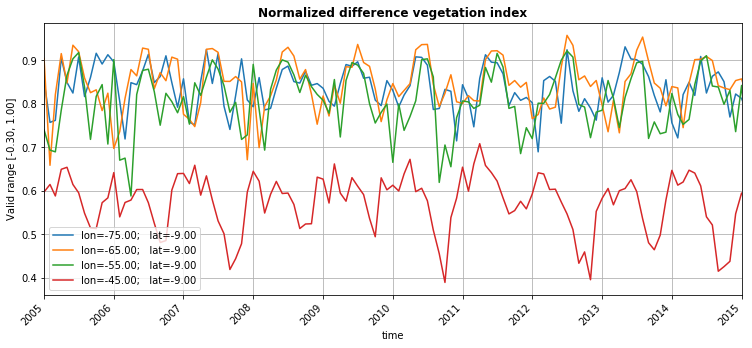

In [20]:
# Some coordinates.
lons = np.arange(-75, -44, 10)
lat = -9

# Time range.
BEGIN = 2005; END = 2015

# Create figure.
plt.figure(figsize=(12.5, 5))

# All plots in same figure.
for i in range(lons.size):
    lon = lons[i]

    NDVI_re_mm.ndvi.sel(longitude=lon, latitude=lat, method="nearest").\
                    sel(time=slice(str(BEGIN), str(END))).\
                    plot(label="lon=%.2f;   lat=%.2f" %(lon, lat))
    
plt.title("Normalized difference vegetation index", weight="bold")
plt.ylabel("Valid range [-0.30, 1.00]")
plt.xlim(pd.Timestamp(str(BEGIN)), pd.Timestamp(str(END)))
plt.xticks(pd.date_range(start=str(BEGIN), end=str(END), freq="1YS"))
plt.tick_params(axis="x", rotation=45)
plt.grid()
plt.legend();

In [21]:
# Linear trends.
ADA = tst.AnomalyDataArray(NDVI_mm)
ADA.get_linear_parameters()

/home/alex/anaconda3/envs/climate36/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: invalid value encountered in greater
  return func(*args2)


Please compare the above time series with the one shown in Figure 1 of Papagiannopoulou, C.et al. 2017.

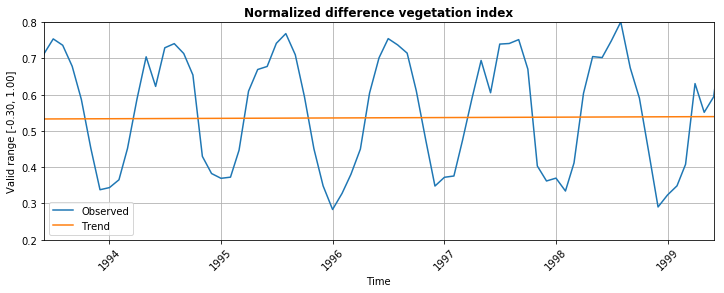

In [22]:
ADA.plot_trend(pix_lon=-87.5, pix_lat=37.5, 
               title="Normalized difference vegetation index", 
               ylabel="Valid range [-0.30, 1.00]",
               lim=("1993-06", "1999-06"))
plt.grid()
plt.ylim((0.2, 0.8));

In [23]:
# Angular coefficient for each location.
DATA_ang = ADA.parameters[0].values

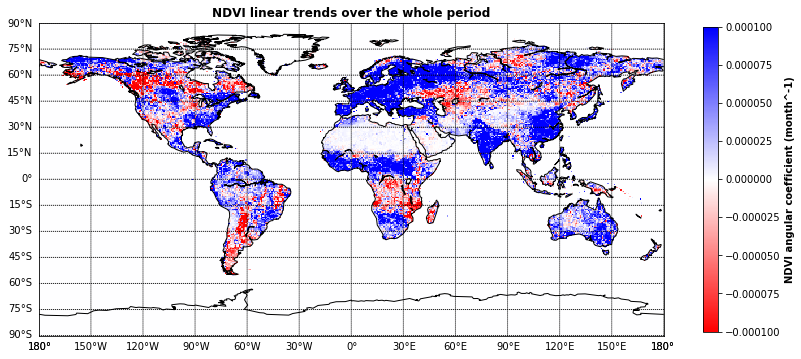

In [24]:
# Angular.
dt.global_scalar(DATA_ang, LON, LAT, clim=(-1e-4, 1e-4), cmap=plt.cm.bwr_r,
                 title="NDVI linear trends over the whole period",
                 clabel="NDVI angular coefficient (month^-1)")

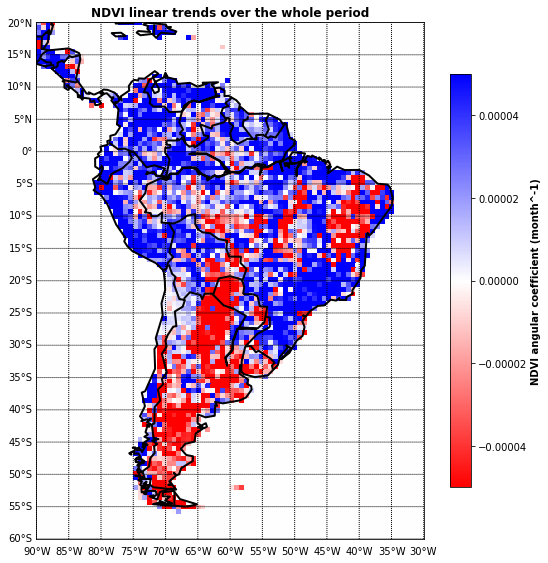

In [25]:
# Angular.
dt.regional_scalar(DATA_ang, LON, LAT, loni, lonf, lati, latf, 
                   clim=(-0.5e-4, 0.5e-4), cmap=plt.cm.bwr_r, line_width=2,
                   title="NDVI linear trends over the whole period",
                   clabel="NDVI angular coefficient (month^-1)")